In [1]:
import pickle, os
import numpy as np
import math

snapshot_dir = os.path.realpath('../generative_playground/molecules/train/genetic/data')
root_name = 'AA2scan8_v2_lr0.1_ew0.1.pkl'
root_name = 'AAscan8_v2_lr_0.1_ew_0.1.pkl'
root_name = 'Ascan8_v2_lr0.03_ew0.1.pkl'


with open(snapshot_dir + '/' + root_name,'rb') as f:
    coeffs = pickle.load(f)
    
coeff_mat = np.array(list(coeffs.values()))
coeff_mean = coeff_mat.mean(axis=0)
coeff_std = coeff_mat.std(axis=0)*math.sqrt(coeff_mat.shape[1])*.2
print(coeff_mat.shape)
print(coeff_mean, coeff_std)

(115, 301149)
[ 3.5287054 -3.0209603 -3.0923486 ... -1.4158039 -1.6016817 -1.4589745] [40.312756 41.415264 55.60755  ... 75.65074  66.66494  72.543335]


In [2]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=0.99,svd_solver='full')
pca.fit(coeff_mat)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.explained_variance_)
pca_coeffs = pca.transform(coeff_mat)
zero_transf = pca.transform(np.zeros_like(coeff_mat[:1]))
dummy_norm = pca.transform(coeff_mean + coeff_std*np.random.randn(*(coeff_mat.shape)))

[0.08142207 0.13373049 0.15854254 0.18091539 0.201993   0.22253332
 0.24193172 0.26052532 0.27823234 0.29555425 0.31262457 0.3294592
 0.34539354 0.36105245 0.37599418 0.39047447 0.4048144  0.41882795
 0.4325087  0.4458914  0.4589216  0.4717535  0.48430815 0.49668258
 0.50885314 0.5205876  0.53211546 0.54350394 0.55465263 0.56555
 0.5762859  0.586789   0.59700716 0.6069651  0.6168189  0.6265073
 0.6359006  0.6452509  0.6543105  0.66313565 0.67180395 0.6803202
 0.68875045 0.697012   0.7050142  0.712882   0.7206412  0.72821474
 0.73565483 0.7430579  0.75036144 0.7574679  0.76445705 0.77131075
 0.7780563  0.78472495 0.79124457 0.79749745 0.8036052  0.8095795
 0.81554353 0.8214613  0.82705426 0.8324897  0.83790356 0.8432024
 0.8484257  0.8535991  0.85869646 0.8636811  0.8685233  0.8733304
 0.87805444 0.8826685  0.8872006  0.89164627 0.895908   0.900164
 0.9043242  0.90838504 0.9123352  0.9161765  0.9199132  0.9235997
 0.92722297 0.9307417  0.9342027  0.9376125  0.94095176 0.944225
 0.947417

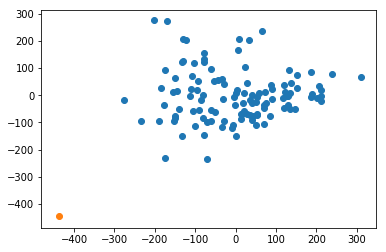

In [4]:
from matplotlib import pyplot as plt
plt.scatter(pca_coeffs[:,0], pca_coeffs[:,1])
plt.scatter(zero_transf[:, 0], zero_transf[:,1])
# plt.scatter(dummy_norm[:,0], dummy_norm[:,1])

In [7]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

#     plt.xlim(-9., 5.)
#     plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)



# Fit a Gaussian mixture with EM using five components


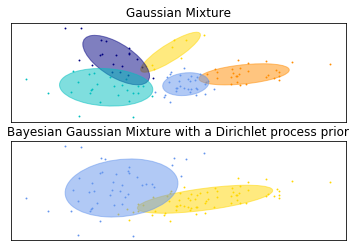

In [40]:
X = pca_coeffs[:,:2]

gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
# this seems to virtually always return 2 components, no matter how I vary the weight_concentration_prior
dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        weight_concentration_prior=1,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

[0.0021168693142007656, 0.004278853501537987, 0.009041326885829738, 0.42385526465478174, 0.5607076856436499]


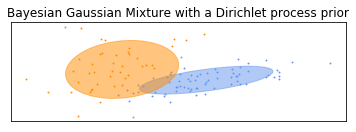

In [57]:
# and now do it on the full vectors, instead of the PCA-reduced ones
X = pca_coeffs[:,:2]

dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        weight_concentration_prior=1,
                                        covariance_type='full').fit(X)
print(sorted(dpgmm.weights_))
plot_results(X[:,:2], dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()